In [1]:
pip install mealpy==2.5.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 898.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.0/378.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 60.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install mafese==0.1.9

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 3.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
# imports

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import mafese as mfse

2024-05-01 21:50:05.787138: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 21:50:05.787270: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 21:50:05.910566: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# loading the images
train_dir = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train"
test_dir = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test"

# generator
def datagen(func):
  train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
              preprocessing_function=func,
              horizontal_flip = True,
              vertical_flip = True,
              rotation_range = 0.5,
              width_shift_range = 0.25,
              height_shift_range = 0.25,
              shear_range = 0.2,
              zoom_range = 0.4,
              validation_split = 0.2)

  test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
              preprocessing_function=func,
              validation_split = 0.0)

  test_gen_2 = tf.keras.preprocessing.image.ImageDataGenerator(
              preprocessing_function=func,
              validation_split = 0.2)

  pred_gen = tf.keras.preprocessing.image.ImageDataGenerator(
              preprocessing_function=func,
              validation_split = 0.2)

  train_set = train_gen.flow_from_directory(train_dir, class_mode = "binary", batch_size = 128, target_size = (224,224), shuffle = True, subset = 'training')
  test_set = test_gen.flow_from_directory(test_dir, class_mode = "binary", batch_size = 128, target_size = (224,224), shuffle = False, subset='training')
  val_set = test_gen_2.flow_from_directory(train_dir, class_mode = "binary", batch_size = 128, target_size = (224,224), shuffle = False, subset='validation')
  pred_tr_set = pred_gen.flow_from_directory(train_dir, class_mode = "binary", batch_size = 128, target_size = (224,224), shuffle = False, subset = 'training')
  return train_set, test_set, val_set, pred_tr_set

In [5]:
import shutil 

src_path = r"/kaggle/input/fake-image-model/r152full_final.keras"
dst_path = r"/kaggle/working/"
shutil.copy(src_path, dst_path)

'/kaggle/working/r152full_final.keras'

In [6]:
model = tf.keras.models.load_model("/kaggle/working/r152full_final.keras")
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet152v2 (Functional)        │ (None, 7, 7, 2048)     │    58,331,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,465,544 (360.36 MB)

 Trainable params: 18,064,898 (68.91 MB)

 Non-trainable params: 40,270,848 (153.62 MB)

 Optimizer params: 36,129,798 (137.82 MB)

In [7]:
tr_set, te_set, v_set, pr_set = datagen(tf.keras.applications.resnet_v2.preprocess_input)

Found 80000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 80000 images belonging to 2 classes.


In [8]:
model.evaluate(te_set)

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.

I0000 00:00:1714600459.563472      86 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714600459.654689      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


157/157 ━━━━━━━━━━━━━━━━━━━━ 182s 859ms/step - accuracy: 0.9752 - loss: 0.0687


W0000 00:00:1714600594.025784      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[0.08277688175439835, 0.9693999886512756]

In [9]:
# getting feature outputs

pooling_model = tf.keras.Model(model.inputs, model.layers[-2].output)
train_features = pooling_model.predict(pr_set)
train_labels = pr_set.labels
test_features = pooling_model.predict(te_set)
test_labels = te_set.labels
train_features.shape, train_labels.shape, test_features.shape, test_labels.shape

625/625 ━━━━━━━━━━━━━━━━━━━━ 494s 772ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 117s 746ms/step


((80000, 2048), (80000,), (20000, 2048), (20000,))

In [10]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()
mlp.fit(train_features, train_labels)
mlp.score(test_features, test_labels), mlp.score(train_features, train_labels)

(0.973, 1.0)

In [11]:
# testing and comparing algorithms
from mafese.wrapper.mha import MhaSelector
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

algos = ['OriginalCRO']
scores = []
num_feat = []

for i in range(len(algos)):
      feat_selector = MhaSelector(problem="classification", estimator="ann", optimizer=algos[i], transfer_func="vstf_01", optimizer_paras={
          'epoch': 10,
          'pop_size': 30,
      })
      feat_selector.fit(train_features, train_labels, verbose=False, fit_weights=(1.0, 0.0))
      train_features_transform = feat_selector.transform(train_features)
      test_features_transform = feat_selector.transform(test_features)
      ANN = MLPClassifier()
      ANN.fit(train_features_transform, train_labels)
      scores.append(ANN.score(test_features_transform, test_labels))
      num_feat.append(len(feat_selector.selected_feature_indexes))

In [12]:
scores

[0.97305]

In [13]:
num_feat

[1869]

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:645: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



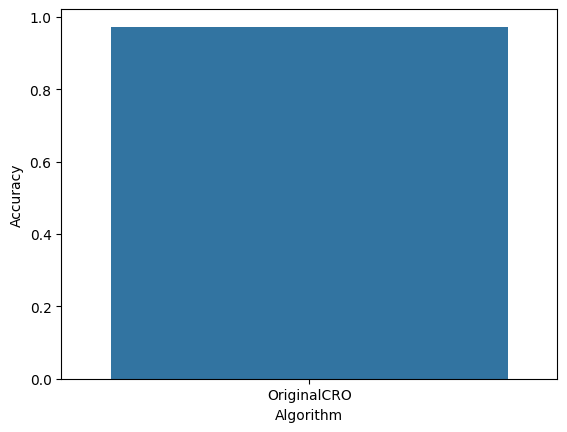

In [14]:
# scores chart

bplot = sns.barplot(x=algos, y=scores)
bplot.set(xlabel='Algorithm', ylabel='Accuracy')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:645: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



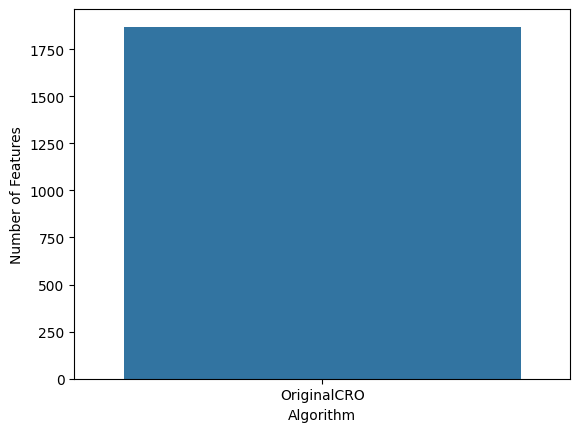

In [15]:
# n_feat chart

bplot = sns.barplot(x=algos, y=num_feat)
bplot.set(xlabel='Algorithm', ylabel='Number of Features')
plt.show()

In [16]:
feat_selector.get_best_obj_and_fit()

{'obj': 0.9776, 'fit': 0.9776}

In [17]:
feat_selector.selected_feature_solution

array([1, 1, 1, ..., 0, 1, 1])

In [18]:
np.savetxt('sol.txt', feat_selector.selected_feature_indexes)
np.savetxt('solmask.txt', feat_selector.selected_feature_masks)